In [2]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from genes_annotations import *
from autoencoder import *
from utils import *

## 0 vs 1

In [2]:
model0 = torch.load('model_0.pth')

In [3]:
model1 = torch.load('model_1.pth')

In [4]:
viann0 = model0.encoder[0].get_VIANN()

AttributeError: 'MaskedLinear' object has no attribute 'var_W'

In [10]:
viann1 = model1.encoder[0].get_VIANN()

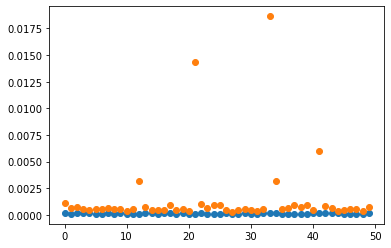

In [19]:
plt.scatter(range(50), viann0.numpy()[:50])
plt.scatter(range(50), viann1.numpy()[:50])

In [18]:
viann0.median(), viann1.median()

(tensor(0.0001), tensor(0.0006))

In [20]:
df0 = pd.DataFrame(viann0.numpy())

In [21]:
df1 = pd.DataFrame(viann1.numpy())

In [22]:
df0

,0
0,0.000139
1,0.000115
2,0.000137
3,0.000153
4,0.000131
...,...
10141,0.000135
10142,0.000130
10143,0.000097
10144,0.000130


In [24]:
filename = "../data_tisch2/Glioma_GSE102130_expression.h5"

h5 = read_h5(filename)

selected_genes = get_all_genes(h5)
goterm, genes_go, all_go, all_genes = get_all_gene_annotations(h5)

HMS:0:00:13.049463 606,840 annotations READ: ../goa_human.gaf 
../go.obo: fmt(1.2) rel(2021-05-01) 50,605 GO Terms; optional_attrs(consider replaced_by)


In [26]:
df0['genes'] = all_genes

In [28]:
df1['genes'] = all_genes

In [31]:
df0.sort_values(by=0, ascending=False)

,0,genes
7147,0.000359,RDH12
7467,0.000337,RSF1
2888,0.000327,EVL
7469,0.000309,RSPO1
1242,0.000300,CCDC134
...,...,...
676,0.000073,ATAD1
5870,0.000073,NXPH1
6504,0.000070,PLEKHG7
10011,0.000069,ZNF653


In [32]:
df1.sort_values(by=0, ascending=False)

,0,genes
9521,0.043059,WEE1
4154,0.026278,IGSF1
33,0.018644,ABCC8
724,0.017935,ATP1A2
1281,0.017395,CCNB1
...,...,...
5940,0.000212,OR1L8
9852,0.000187,ZNF334
8887,0.000186,TMSB4X
8545,0.000184,TAOK3


In [34]:
df = pd.DataFrame({'x1':viann0.numpy(), 'x2':viann1.numpy(), 'genes':all_genes})

In [40]:
df[['x1','x2']].corr(method='kendall')

,x1,x2
x1,1.000000,0.101657
x2,0.101657,1.000000


## Shapley values

In [3]:
import shap

In [4]:
filename = "../data_tisch2/Glioma_GSE102130_expression.h5"

h5 = read_h5(filename)

In [5]:
selected_genes = get_all_genes(h5)

In [6]:
goterm, genes_go, all_go, all_genes = get_all_gene_annotations(h5, levels=[4], kinds=['biological_process'])

HMS:0:00:08.795907 606,840 annotations READ: ../goa_human.gaf 
../go.obo: fmt(1.2) rel(2021-02-01) 50,515 GO Terms; optional_attrs(consider replaced_by)


In [7]:
mask = build_mask(h5,genes_go,all_go,all_genes)

In [8]:
expr_mat = build_expr_mat(h5)
expr_mat = select_gene_expr_v2(h5, expr_mat, all_genes)
std_expr_mat = min_max_normalisation(std_normalisation(expr_mat))

'build_expr_mat'  458.32 ms
'select_gene_expr_v2'  341.01 ms


In [9]:
table = pd.read_csv('../data_tisch2/Glioma_GSE102130_CellMetainfo_table.tsv', delimiter='\t')
targets = np.array(table['Cluster'])

In [10]:
dataset, loader = get_train_loader(std_expr_mat, targets)

In [11]:
std_expr_mat.shape

(4058, 8925)

In [12]:
model = torch.load('model_clf.pth')

In [13]:
batch = next(iter(loader))
seq, _ = batch

N_bg = 20
N_test = 400

seq = torch.Tensor(std_expr_mat)

ind_bg = torch.randperm(len(seq))[:N_bg]
ind_test = torch.randperm(len(seq))[:N_test]

background = seq[ind_bg]
test = seq[ind_test]

#background = torch.Tensor(std_expr_mat[:20,:])
#test = torch.Tensor(std_expr_mat[20:1000,:])

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [14]:
seq.shape

torch.Size([4058, 8925])

In [15]:
len(shap_values)

15

In [20]:
shap_values.shape

AttributeError: 'list' object has no attribute 'shape'

In [21]:
for i in range(len(shap_values)):
    np.savetxt('../shapley/'+str(i)+'.txt', shap_values[i])

In [ ]:
shap.summary_plot(shap_values[1], features=test, feature_names=all_genes)

In [1]:
1

1